## Imports and installs

In [1]:
%cd /content/drive/MyDrive/github/enterpret 

/content/drive/MyDrive/github/enterpret


In [ ]:
!pip install transformers sentence-transformers datasets sentencepiece 

In [10]:
# !pip install transformers datasets
import sentencepiece
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import torch

import pandas as pd
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm.auto import tqdm
from sentence_transformers import models
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import SentenceTransformer, CrossEncoder, util, losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, BinaryClassificationEvaluator


import json
import matplotlib.pyplot as plt


##

In [4]:
# utils

def compute_metrics(predictions, labels)-> dict:
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)
    # auc_roc = roc_auc_score(labels, predictions)
    result = {"accuracy": accuracy, "precision":precision, "recall":recall, "f1":f1}
    return result

In [5]:
train_file = "./data/train.csv"
test_file = "./data/test.csv"
data_files = {}
data_files["train"] = train_file
data_files["test"] = test_file

raw_datasets = load_dataset('csv', data_files=data_files)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f52713111e320066/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

'cpu'

## 1. Pretrained NLI models

### get dataloader

In [ ]:
def get_dataloaders_nli(raw_datasets, tokenizer):

    num_labels = 3
    label_list = [0.0,1.0]
    non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
    sentence1_key, sentence2_key = non_label_column_names[:2]
    label_to_id = {v: i for i, v in enumerate(label_list)}
    padding = "max_length"

    def preprocess_function(examples):
        texts = (examples[sentence1_key],examples[sentence2_key])
        result = tokenizer(*texts, padding=padding, max_length=100, truncation=True, return_tensors="pt")
        # if "label" in examples:
        if label_to_id is not None:
            # Map labels to IDs (not necessary for GLUE tasks)
            result["labels"] = [label_to_id[l] for l in examples["label"]]
        else:
            # In all cases, rename the column to labels because the model will expect that.
            result["labels"] = examples["label"]
        
        return result

    processed_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        remove_columns=raw_datasets["train"].column_names,
        desc="Running tokenizer on dataset",
    )


    train_dataset = processed_datasets["train"]
    eval_dataset = processed_datasets["test"]
    data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=(8))
    train_dataloader = DataLoader(train_dataset, collate_fn=data_collator, batch_size=16)
    eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=16)

    return train_dataloader, eval_dataloader

In [ ]:
results = {}
task =["train_set", "test_set"]
model_names = ["cross-encoder/nli-MiniLM2-L6-H768", "cross-encoder/nli-deberta-v3-xsmall", "cross-encoder/nli-deberta-base"]


### testing pretrained Cross-Encoders on test data


In [ ]:

for model_name in model_names:
    # model_name = "cross-encoder/nli-deberta-v3-base"
    config = AutoConfig.from_pretrained(model_name, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
    model.to(device)
    results[model_name] = {}

    train_dataloader, eval_dataloader = get_dataloaders_nli(raw_datasets, tokenizer)
    all_predictions, all_labels = [], []
    dataloaders = (train_dataloader, eval_dataloader)


    # for i in range(len(task)):
    model.eval()
    for step, batch in enumerate(tqdm(eval_dataloader)):
        with torch.no_grad():
            # print(batch)
            batch = batch.to(device)
            scores = model(**batch).logits
            # labels = ['contradiction', 'entailment', 'neutral']
            label_mapping = [0, 1, 1]
            predictions = [label_mapping[score_max] for score_max in scores.argmax(dim=1)]
            all_predictions.extend(predictions)
            all_labels.extend(batch["labels"].cpu().numpy())
            # print(scores, predictions, batch["labels"].numpy())
            # if step>10:break
              
    results[model_name] = compute_metrics(all_predictions, all_labels)


# with open('pretrained-nli-results-n1.json', 'w') as fp:
    # json.dump(results, fp)

In [ ]:
results
# texts = ["i love you", "i love you so so much"]

# result = tokenizer(*texts, padding="max_length", max_length=100, truncation=True, return_tensors="pt")
# # dataloader = 
# # dir(model)
# model(**result)

{'cross-encoder/nli-MiniLM2-L6-H768': {'accuracy': 0.4458888888888889,
  'precision': 0.36415868673050616,
  'recall': 0.8870376541152949,
  'f1': 0.5163417709242557},
 'cross-encoder/nli-deberta-v3-xsmall': {'accuracy': 0.46266666666666667,
  'precision': 0.3783317862352473,
  'recall': 0.9506831056314562,
  'f1': 0.5412635173591349},
 'cross-encoder/nli-deberta-base': {'accuracy': 0.44222222222222224,
  'precision': 0.3713848897948783,
  'recall': 0.9713428857047651,
  'f1': 0.5373271889400921}}

In [ ]:
import json

# with open('results.json', 'w') as fp:
    # json.dump(results, fp)

UnsupportedOperation: ignored

## 2.Pretrained sentence-transformers

In [ ]:
from sklearn.metrics import accuracy_score, recall_score

def predict_labels(outputs, labels, threshold):
    predicted_labels = [1.0 if o >= threshold else 0.0 for o in outputs]
    return predicted_labels

def calculate_metrics(outputs, labels, threshold_values):
    all_results = {'accuracy':[], 'f1':[], 'precision':[], 'recall':[]}
    for threshold in threshold_values:
        predicted_labels = predict_labels(outputs, labels, threshold)
        # print(outputs[:10], labels[:10])
        results = compute_metrics(predicted_labels, labels)
        all_results["accuracy"].append(results["accuracy"])
        all_results["recall"].append(results["recall"])
        all_results["precision"].append(results["precision"])
        all_results["f1"].append(results['f1'])
#     return accuracy_scores, recall_scores
    return all_results


In [ ]:
models = ["sentence-transformers/sentence-t5-xl"]

In [ ]:
sts_results = {}
all_results = None

In [ ]:
# !pip install -U sentence-transformers
for model_id in models:
    from sentence_transformers import SentenceTransformer, util
    # sentences = ["I'm happy", "I'm full of happiness"]

    #Compute embedding for both lists
    outputs = []
    model = SentenceTransformer(model_id)
    model.to(device)

    for i in tqdm(range(len(raw_datasets["test"]))):
        embedding_1= model.encode(raw_datasets["test"]['text'][i], convert_to_tensor=True)
        embedding_2 = model.encode(raw_datasets["test"]['reason'][i], convert_to_tensor=True)

        sim = util.pytorch_cos_sim(embedding_1, embedding_2)    
        # print(sim)
        outputs.append(sim.item())


    threshold_values = [i/100 for i in range(101)]
    all_results = calculate_metrics(outputs, raw_datasets["test"]['label'] , threshold_values)


Best Threshold is 0.8 and best reults are - 
 {'accuracy': 0.8283333333333334, 'f1': 0.7337584008271584, 'precision': 0.7598144182726624, 'recall': 0.7094301899366877}


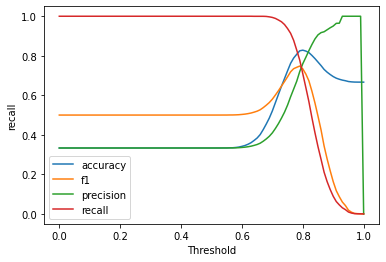

In [ ]:

for k,v in all_results.items():
  # print(k,v)      
  plt.plot(threshold_values, v, label=k)
  plt.xlabel('Threshold')
  plt.ylabel(f'{k}')
  plt.legend()
  # plt.legend(k)
  # plt.show()
  # plt.savefig(f"./figs/{model_id.replace('/','-')}_metrics-vs-threshold")


best_metrics_idx = np.argmax(all_results['accuracy']) 
best_metrics = {}
for metric in all_results:
    best_metrics[metric] = all_results[metric][best_metrics_idx] 
print(f"Best Threshold is {threshold_values[best_metrics_idx]} and best reults are - \n {best_metrics}")

sts_results[model_id] = best_metrics

In [ ]:
sts_results[model_id]

{'accuracy': 0.8332222222222222,
 'f1': 0.7492063492063491,
 'precision': 0.7513404825737265,
 'recall': 0.7470843052315894}

In [ ]:
threshold_values = [i/100 for i in range(101)]

best_metrics_idx = np.argmax(all_results['accuracy'])


In [ ]:
# with open('pretrained-sts-results.json', 'r') as fp:
#     all_results = json.load(fp)
    
json_file_path = "./pretrained-sts-results.json"
# save
# with open(json_file_path, 'w') as f:
#      json.dump(all_results, f)

# load
with open(json_file_path, 'r') as j:
     all_results = json.loads(j.read())

In [ ]:
best_metrics = {}
for metric in all_results:
    best_metrics[metric] = all_results[metric][best_metrics_idx] 

In [ ]:
best_metrics, model_id

({'accuracy': 0.8332222222222222,
  'f1': 0.7492063492063491,
  'precision': 0.7513404825737265,
  'recall': 0.7470843052315894},
 'sentence-transformers/sentence-t5-large')

## Without finetuning; vanilla Transformers

In [ ]:
model_name = 'bert-base-uncased'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])


In [11]:
train_inputs = []
debug_inputs = []
n_inputs = len(raw_datasets["train"]["text"])

for i in tqdm(range(n_inputs)):
  score = float(raw_datasets['train']['label'][i])
  train_inputs.append(InputExample(texts=[raw_datasets["train"]['text'][i], raw_datasets["train"]["reason"][i]], label=score))


  0%|          | 0/2061 [00:00<?, ?it/s]

In [ ]:
train_batch_size = 32
train_dataloader = DataLoader(train_inputs, shuffle=True, batch_size=train_batch_size)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=len(label2int))


## wandb log


In [ ]:
# !pip install wandb
import wandb
import os
os.environ['WANDB_API_KEY'] = '46c39bbac8b187eeb815386597ca25ba414d4c5e'
os.environ['WANDB_PROJECT'] = 'enterpret'
wandb.login()

True

In [ ]:
name=model_id
name
run = wandb.init(project="enterpret", name=name, job_type="testing", group="pretrained")

In [ ]:
# metrics = all_results.keys()
# # print(data, data[name])
# for metric in metrics:
#   print(metric, all_results[metric])
  # wandb.log(metric:)
# for metric in data[name]:
# # wandb.log(data[name])
#   print(metric)
print(best_metrics)

{'accuracy': 0.8283333333333334, 'f1': 0.7337584008271584, 'precision': 0.7598144182726624, 'recall': 0.7094301899366877}


In [ ]:
run.log(best_metrics)

In [ ]:
wandb.finish()

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.82833
f1,0.73376
precision,0.75981
recall,0.70943
